Se carga la base de datos

Se trabaja con el módulo auxiliar process_data, el cual define una carga personalizada para estos ejemplos de ataques a modelos fedrados. Para más detalles sobre como efectuar la carga de datos con Flex ir a la documentación correspondiente.

Este módulo permite la carga de dataset de procesamiento de imágenes como: Mnist, Fmnist, Cifar10 y Cifar100. Además del dataset tabular nursery.

In [1]:
from process_data import *
from copy import deepcopy

flex_data, server_id = load_and_preprocess_horizontal(dataname="mnist", trasnform=False, nodes=2)
adv_data = flex_data[server_id]

torch.Size([60000, 28, 28])


A continuación, se define la arquitectura de los modelos locales de los clientes. Para el presente ejemplo se trabaja con modelos neuronales de pytorch.

Se utiliza el módulo networks_models, quien contiene una serie de modelos neuronales auxiliares de pytorch, para el trabajo con las bases de datos anteriormente mencionadas. Además se utiliza el módulo auxiliar networks_execution, que define la ejecución del entrenamiento y otros detalles de estos modelos.

Para establecer un modelo personalizado, ir a la documentación de Flex.

In [2]:
from networks_models import *
from networks_execution import *
from flex.pool import init_server_model
from flex.model import FlexModel

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

net_config = ExecutionNetwork()

@init_server_model
def build_server_model():
    server_flex_model = FlexModel()

    criterion, model, optimizer = net_config.for_fd_server_model_config()

    server_flex_model["model"] = model.to(device)
    # Required to store this for later stages of the FL training process
    server_flex_model["criterion"] = criterion
    server_flex_model["optimizer_func"] = optimizer
    server_flex_model["optimizer_kwargs"] = {}

    return server_flex_model

Se define la arquitectura del modelo federado

In [3]:
from flex.pool import FlexPool
clients = 2

pool = FlexPool.client_server_pool(
        fed_dataset= flex_data, server_id=server_id, init_func = build_server_model
    )

#selected_test_clients_pool = pool.clients.select(clients)
#selected_test_clients = selected_test_clients_pool.clients

Se define la función para desplegar el modelo global en cada cliente

In [4]:
from flex.pool.decorators import (  # noqa: E402
    deploy_server_model,
)

@deploy_server_model
def deploy_serv(server_flex_model: FlexModel): 

    new_model = deepcopy(server_flex_model)

    return new_model

#pool.servers.map(deploy_serv, selected_test_clients)

Se define la ronda de entrenamiento local de un cliente, empleando el módulo networks_execution

In [5]:
def train(client_flex_model: FlexModel, client_data: Dataset):

    train_dataset = client_data.to_torchvision_dataset(transform = mnist_transform())
    client_dataloader = DataLoader(train_dataset, batch_size = 256)

    model = client_flex_model["model"]
    model = model.to(device)

    client_flex_model["previous_model"] = deepcopy(model)
    optimizer = client_flex_model["optimizer_func"]
    criterion = client_flex_model["criterion"]

    net_config.trainNetwork(local_epochs = 1, criterion = criterion, optimizer = optimizer,
                            momentum = 0.9, lr = 0.005, trainloader = client_dataloader, testloader= None, 
                            model=model)
    
    return client_flex_model

#selected_test_clients.map(train)

Se efectúa la agregación del modelo federado

In [6]:
from flex.pool import collect_client_diff_weights_pt
from flex.pool import fed_avg
from flex.pool import set_aggregated_diff_weights_pt


#pool.aggregators.map(collect_client_diff_weights_pt, selected_test_clients)
#pool.aggregators.map(fed_avg)
#pool.aggregators.map(set_aggregated_diff_weights_pt, pool.servers)

Se define el ataque de inferencia

In [ ]:
from my_models_attacks.inversed_gradient import *
from flexclash.model import model_inference_known_a_model_information
import traceback

import matplotlib.pyplot as plt 
import torchvision.transforms as transforms

@model_inference_known_a_model_information
def inferencer(client_model: FlexModel):#Ver lo de la perdida que está dando Nan, puede ser que estoy solo viendo pocas iteraciones de todo y nada se a optimizado
                                                             #Ver bien lo de la media y el std, ver que se escojan los clientes para infestar y que sea a partir de un número de iteraciones
    for param in client_model["model"].parameters():
        if param.grad is None:
            print("No")
    try:
        train_dataset = adv_data.to_torchvision_dataset(transform = mnist_transform())
        mean, std = get_meanstd(train_dataset)
        mean = torch.as_tensor(mean,)[:, None, None]
        std = torch.as_tensor(std,)[:, None, None]
        labels = [torch.as_tensor((label,)) for label in np.array(train_dataset.data.y_data)]
    except Exception as e:
        print(f"Error: {e.__class__.__name__} - {e}")
        tb = traceback.format_exc()
        print(tb)

    num_images = 2
    labels = torch.cat(labels)
    labels=labels.long()

    try:
        output, stats = reconstruction_gradient_attack(client_model["model"], deepcopy(client_model["previous_model"]), train_dataset[0][0].shape, mean, std,
                                                                     num_images = num_images, labels = None)
        count = 0
        countN = 0
        
        for i in range(len(train_dataset)):
            print(train_dataset[i][0].size())
            img = train_dataset[i][0]
            image = img.squeeze()
            transform_to_pil = transforms.ToPILImage()
            image_pil = transform_to_pil(image)
            plt.imshow(image_pil, cmap='gray')
            plt.title("Imagen en Escala de Grises")
            plt.axis('off')
            plt.show()
            countN += 1
            if countN == 10:
                break

        print("Salidas:")
        for img in output:
            image = img.squeeze()
            transform_to_pil = transforms.ToPILImage()
            image_pil = transform_to_pil(image)
            plt.imshow(image_pil, cmap='gray')
            plt.title("Imagen en Escala de Grises")
            plt.axis('off')
            plt.show()
            count+=1
            if count == 10:
                break
    except Exception as e:
        print(f"Error: {e.__class__.__name__} - {e}")
        tb = traceback.format_exc()
        print(tb)
    return client_model


@model_inference_known_a_model_information
def inferencer2(server_model: FlexModel):#Ver lo de la perdida que está dando Nan, puede ser que estoy solo viendo pocas iteraciones de todo y nada se a optimizado
                                                             #Ver bien lo de la media y el std, ver que se escojan los clientes para infestar y que sea a partir de un número de iteraciones

    try:
        train_dataset = adv_data.to_torchvision_dataset(transform = mnist_transform())
        mean, std = get_meanstd(train_dataset)
        mean = torch.as_tensor(mean,)[:, None, None]
        std = torch.as_tensor(std,)[:, None, None]
        labels = [torch.as_tensor((label,)) for label in np.array(train_dataset.data.y_data)]
    except Exception as e:
        print(f"Error: {e.__class__.__name__} - {e}")
        tb = traceback.format_exc()
        print(tb)

    num_images = 2
    labels = torch.cat(labels)
    labels=labels.long()

    try:
        output, stats = reconstruction_gradient_attack_server(data_adv = train_dataset, server_model = server_model["model"], 
                                                              loss_fn = server_model["criterion"], local_lr = 0.001, local_steps = 1,
                                                              dim_imgs = train_dataset[0][0].shape, 
                                                              mean = mean, std = std, num_images = num_images)
        count = 0
        countN = 0
        
        for i in range(len(train_dataset)):
            print(train_dataset[i][0].size())
            img = train_dataset[i][0]
            image = img.squeeze()
            transform_to_pil = transforms.ToPILImage()
            image_pil = transform_to_pil(image)
            plt.imshow(image_pil, cmap='gray')
            plt.title("Imagen en Escala de Grises")
            plt.axis('off')
            plt.show()
            countN += 1
            if countN == 10:
                break

        print("Salidas:")
        for img in output:
            image = img.squeeze()
            transform_to_pil = transforms.ToPILImage()
            image_pil = transform_to_pil(image)
            plt.imshow(image_pil, cmap='gray')
            plt.title("Imagen en Escala de Grises")
            plt.axis('off')
            plt.show()
            count+=1
            if count == 10:
                break
    except Exception as e:
        print(f"Error: {e.__class__.__name__} - {e}")
        tb = traceback.format_exc()
        print(tb)
    return client_model


#selected_test_clients.map(inferencer)

Se evalúa el modelo federado

In [8]:
def evaluate_global_model(server_flex_model: FlexModel, test_data: Dataset):#falta poner esto
    model = server_flex_model["model"]
    model.eval()
    test_loss = 0
    test_acc = 0
    total_count = 0
    model = model.to(device)
    criterion = server_flex_model["criterion"]
    # get test data as a torchvision object
    test_dataset = test_data.to_torchvision_dataset(transform = mnist_transform())
    test_dataloader = DataLoader(
        test_dataset, batch_size=256, shuffle=True, pin_memory=False
    )
    losses = []
    with torch.no_grad():
        for data, target in tqdm(test_dataloader):
            total_count += target.size(0)
            data, target = data.to(device), target.to(device)
            output = model(data)
            losses.append(criterion(output, target).item())
            pred = output.data.max(1, keepdim=True)[1]
            test_acc += pred.eq(target.data.view_as(pred)).long().cpu().sum().item()

    test_loss = sum(losses) / len(losses)
    test_acc /= total_count
    return test_loss, test_acc

#metrics = pool.servers.map(evaluate_global_model)

#loss, acc = metrics[0]
#print(f"Server: Test acc: {acc:.4f}, test loss: {loss:.4f}")

Para limpiar los modelos en memoria. Opcional

In [9]:
def clean_up_models(client_model: FlexModel, _):
    import gc

    client_model.clear()
    gc.collect()

Se definen las rondas de entrenamiento del modelo federado

In [10]:
def train_n_rounds(n_rounds, clients_per_round=20):
    pool = FlexPool.client_server_pool(
        fed_dataset= flex_data, server_id=server_id, init_func=build_server_model
    )
    for i in range(n_rounds):
        print(f"\nRunning round: {i+1} of {n_rounds}")
        selected_clients_pool = pool.clients.select(clients_per_round)
        selected_clients = selected_clients_pool.clients
        pool.servers.map(deploy_serv, selected_clients)
        selected_clients.map(train)
        pool.aggregators.map(collect_client_diff_weights_pt, selected_clients)
        pool.aggregators.map(fed_avg)
        pool.aggregators.map(set_aggregated_diff_weights_pt, pool.servers)
        metrics = pool.servers.map(evaluate_global_model)
        if i != 0:
            selected_clients.map(inferencer)
        selected_clients.map(clean_up_models)
        loss, acc = metrics[0]
        print(f"Server: Test acc: {acc:.4f}, test loss: {loss:.4f}")


Running round: 1 of 5


100%|██████████| 118/118 [00:25<00:00,  4.63it/s]


Después de la modif antes de fedavg tensor(3.1946)


100%|██████████| 40/40 [00:04<00:00,  8.84it/s]


Server: Test acc: 0.9729, test loss: 0.0939

Running round: 2 of 5


100%|██████████| 118/118 [00:23<00:00,  4.99it/s]


Después de la modif antes de fedavg tensor(0.0841)


100%|██████████| 40/40 [00:04<00:00,  8.94it/s]


Diferencia entre el coste tensor(0.9715, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
It: 0. Rec. loss: 0.9715.
Diferencia entre el coste tensor(0.9095, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.8778, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.8353, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.7965, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.7571, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.7239, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.6940, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.6696, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.6466, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia ent

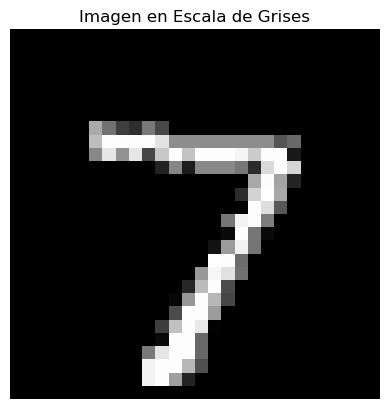

torch.Size([1, 28, 28])


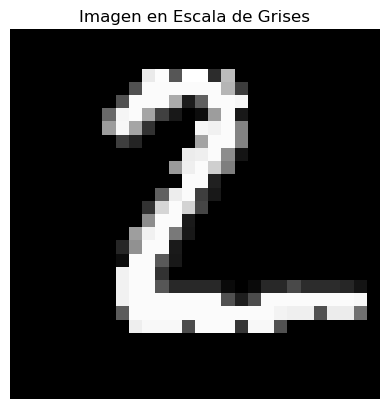

torch.Size([1, 28, 28])


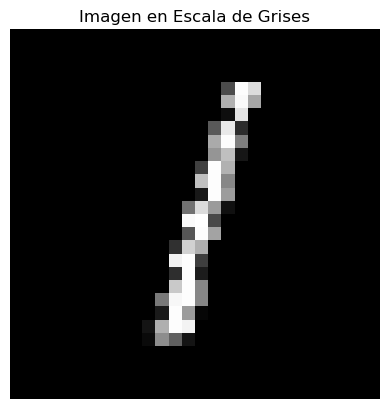

torch.Size([1, 28, 28])


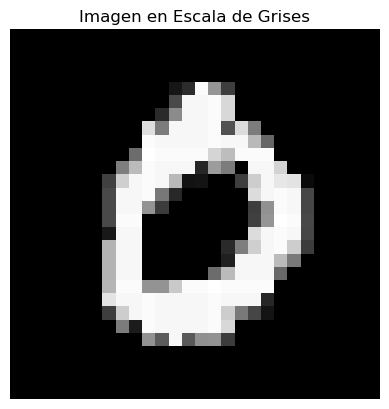

torch.Size([1, 28, 28])


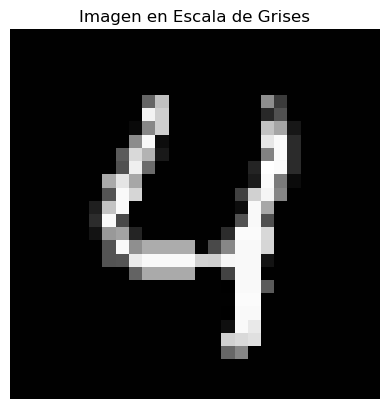

torch.Size([1, 28, 28])


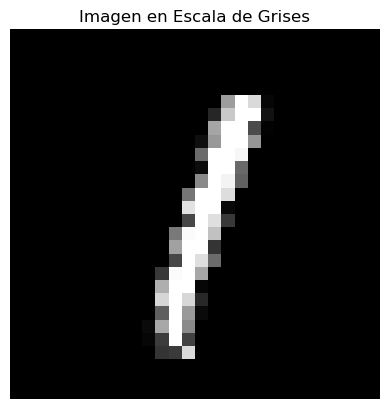

torch.Size([1, 28, 28])


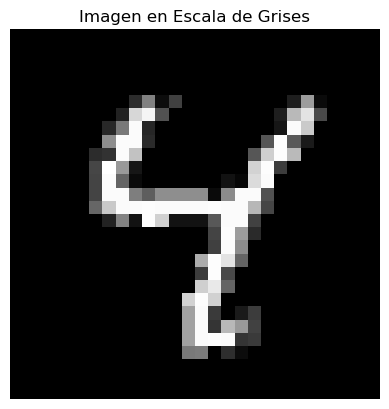

torch.Size([1, 28, 28])


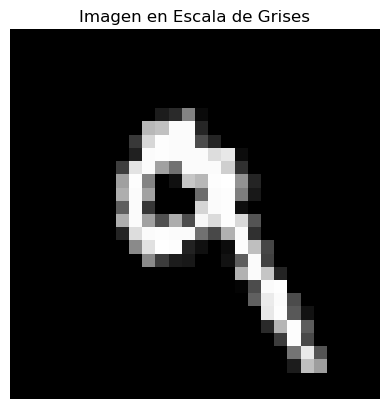

torch.Size([1, 28, 28])


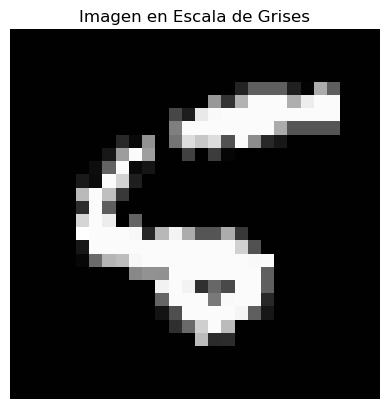

torch.Size([1, 28, 28])


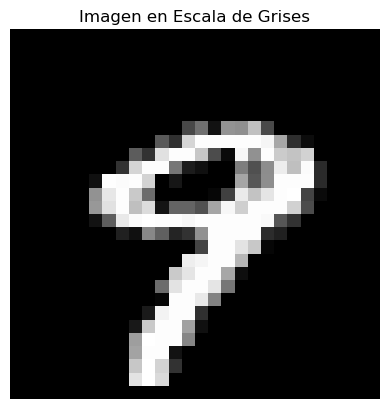

Salidas:


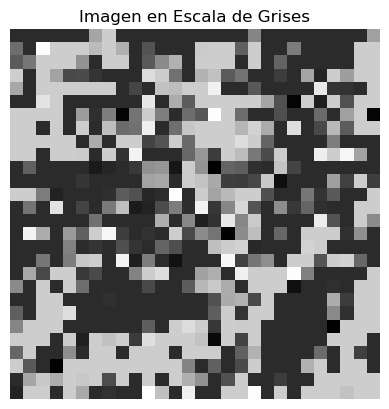

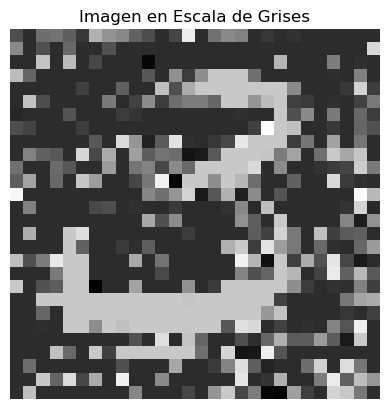

Diferencia entre el coste tensor(0.9445, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
It: 0. Rec. loss: 0.9445.
Diferencia entre el coste tensor(0.9901, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.9473, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.8902, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.8642, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.8271, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.7946, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.7648, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.7377, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.7063, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia ent

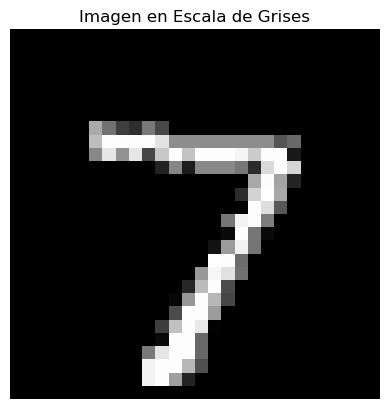

torch.Size([1, 28, 28])


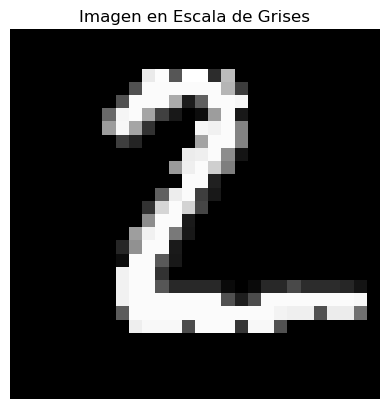

torch.Size([1, 28, 28])


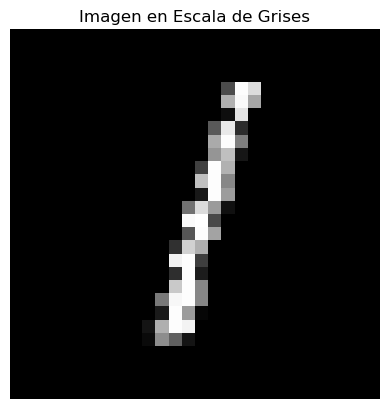

torch.Size([1, 28, 28])


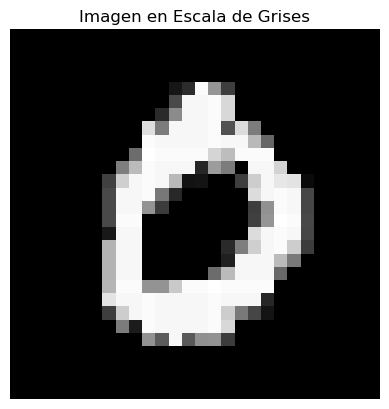

torch.Size([1, 28, 28])


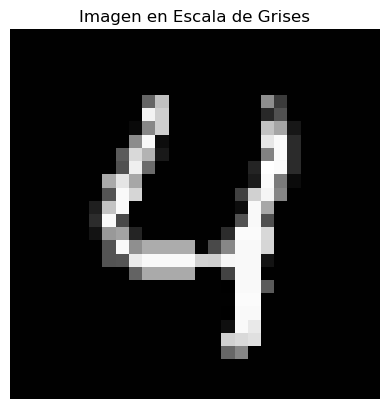

torch.Size([1, 28, 28])


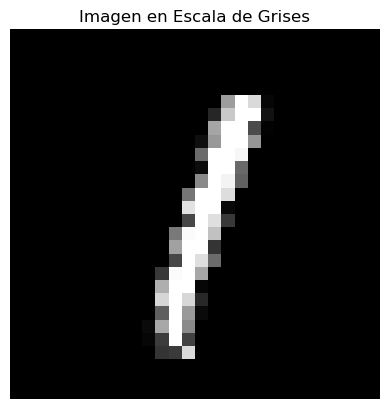

torch.Size([1, 28, 28])


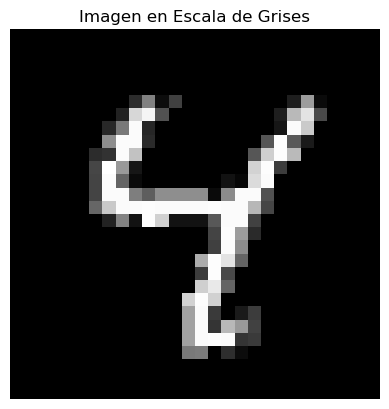

torch.Size([1, 28, 28])


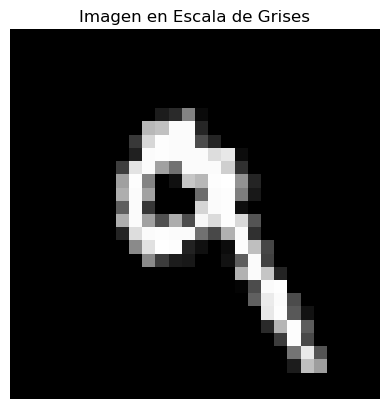

torch.Size([1, 28, 28])


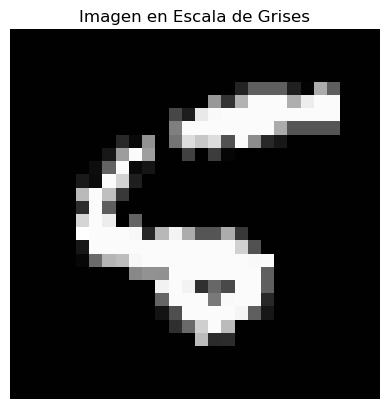

torch.Size([1, 28, 28])


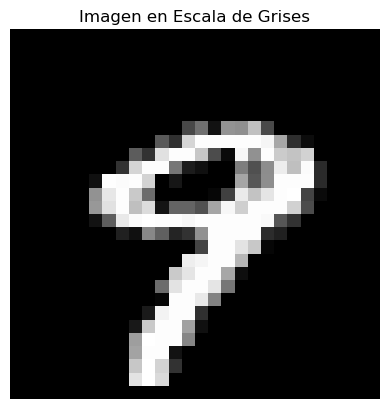

Salidas:


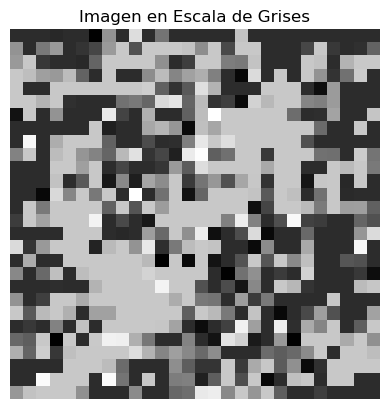

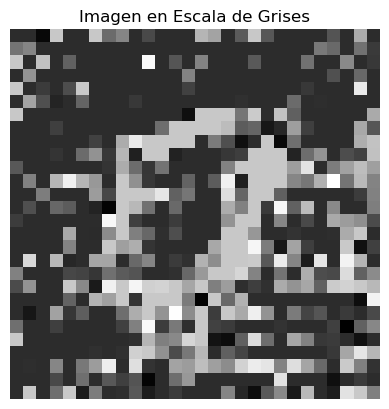

Server: Test acc: 0.9809, test loss: 0.0577

Running round: 3 of 5


100%|██████████| 118/118 [00:24<00:00,  4.77it/s]


Después de la modif antes de fedavg tensor(0.1285)


100%|██████████| 40/40 [00:04<00:00,  8.42it/s]


Diferencia entre el coste tensor(1.0111, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
It: 0. Rec. loss: 1.0111.
Diferencia entre el coste tensor(0.9908, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.9413, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.9001, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.8680, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.8315, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.8038, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.7783, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.7576, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.7347, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia ent

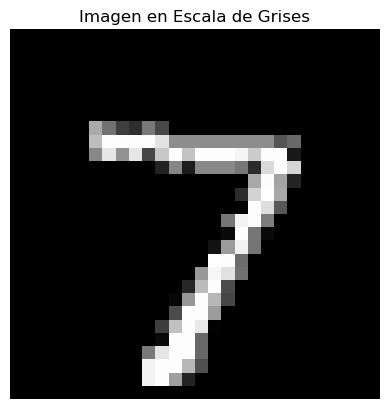

torch.Size([1, 28, 28])


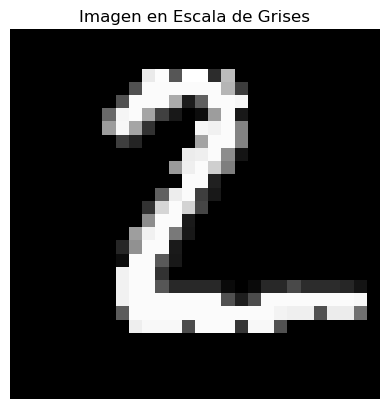

torch.Size([1, 28, 28])


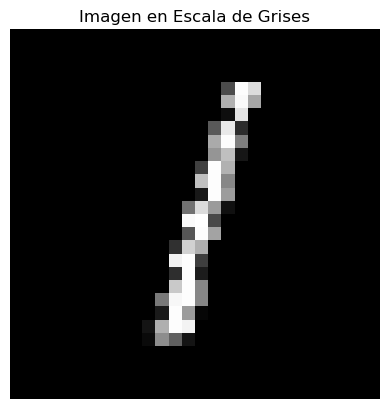

torch.Size([1, 28, 28])


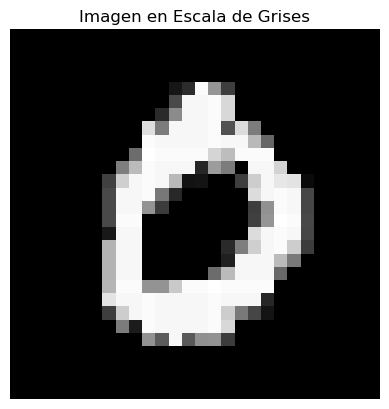

torch.Size([1, 28, 28])


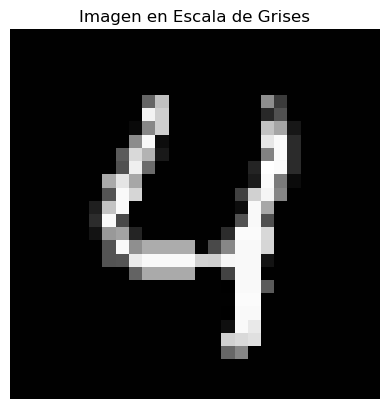

torch.Size([1, 28, 28])


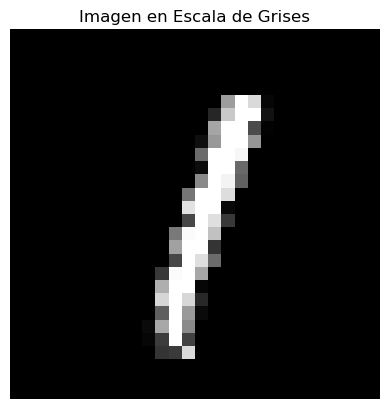

torch.Size([1, 28, 28])


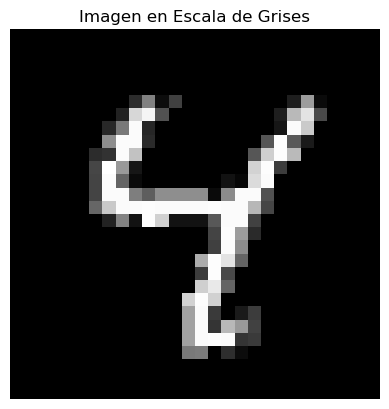

torch.Size([1, 28, 28])


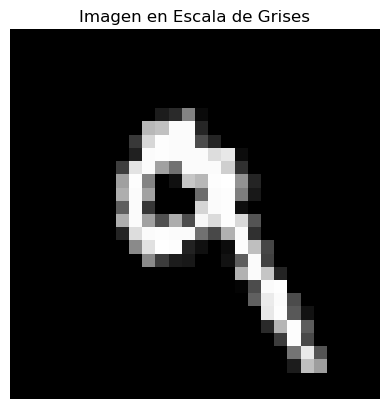

torch.Size([1, 28, 28])


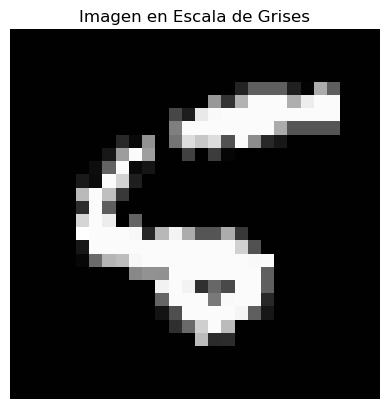

torch.Size([1, 28, 28])


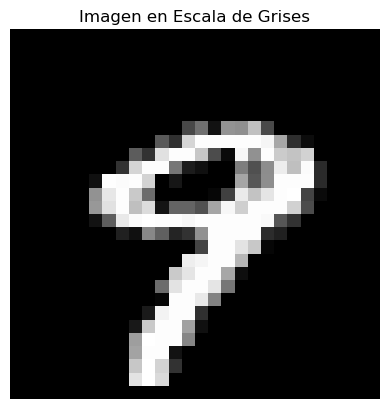

Salidas:


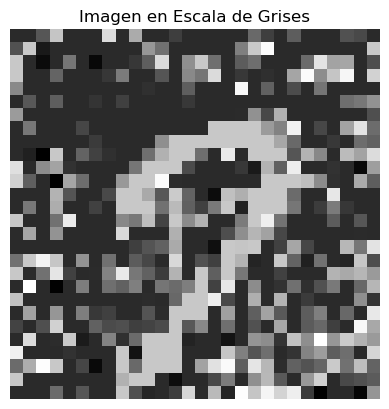

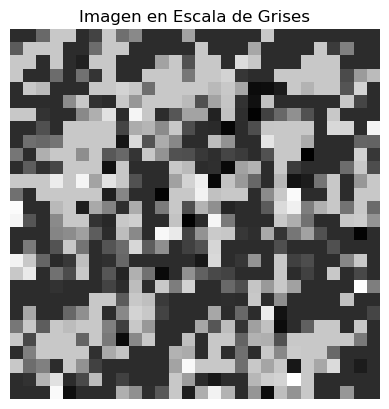

Diferencia entre el coste tensor(0.9840, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
It: 0. Rec. loss: 0.9840.
Diferencia entre el coste tensor(0.9831, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.9426, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.8918, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.8463, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.8129, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.7809, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.7512, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.7290, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.7070, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia ent

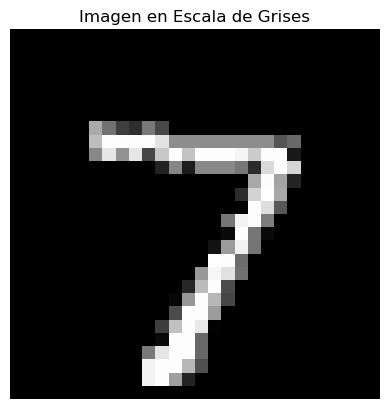

torch.Size([1, 28, 28])


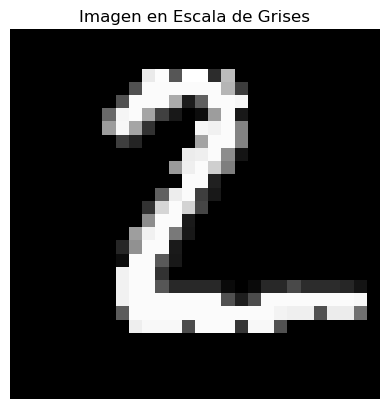

torch.Size([1, 28, 28])


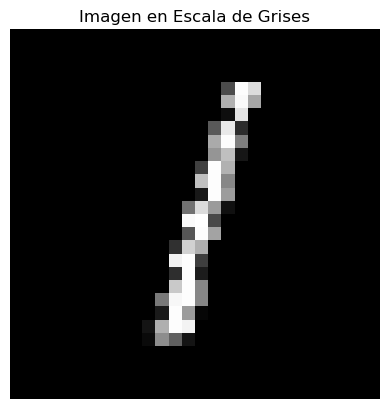

torch.Size([1, 28, 28])


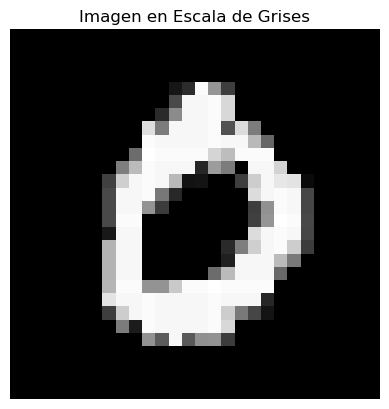

torch.Size([1, 28, 28])


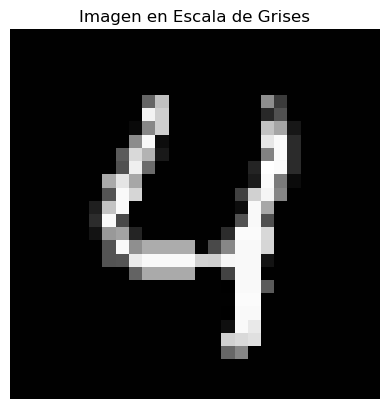

torch.Size([1, 28, 28])


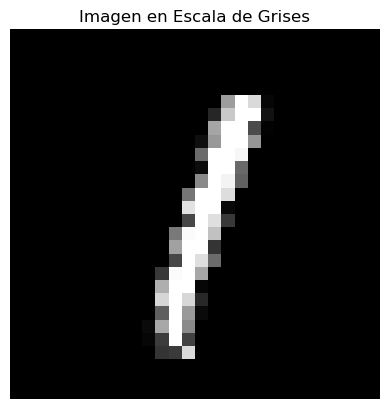

torch.Size([1, 28, 28])


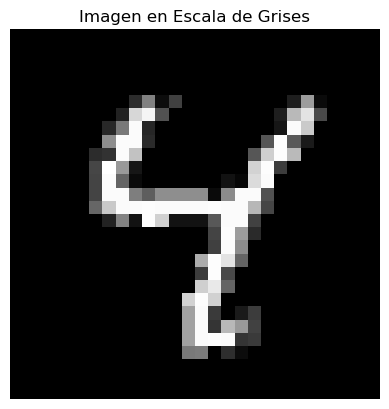

torch.Size([1, 28, 28])


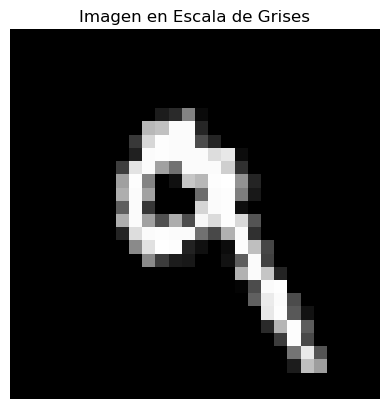

torch.Size([1, 28, 28])


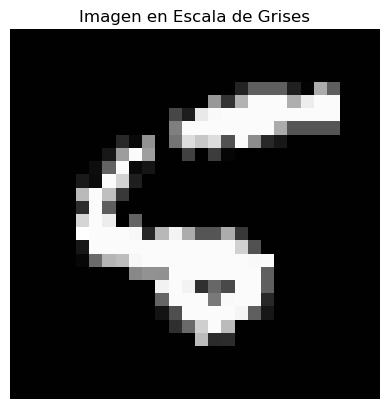

torch.Size([1, 28, 28])


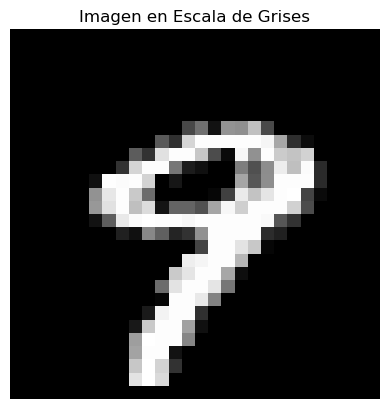

Salidas:


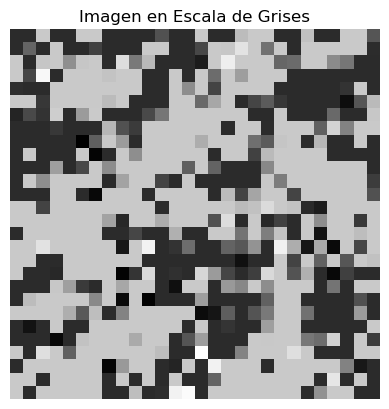

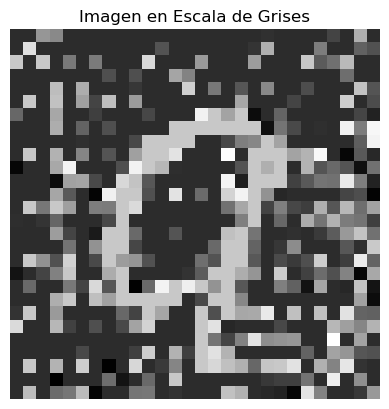

Server: Test acc: 0.9831, test loss: 0.0513

Running round: 4 of 5


100%|██████████| 118/118 [00:24<00:00,  4.87it/s]


Después de la modif antes de fedavg tensor(-0.3808)


100%|██████████| 40/40 [00:04<00:00,  9.03it/s]


Diferencia entre el coste tensor(1.0138, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
It: 0. Rec. loss: 1.0138.
Diferencia entre el coste tensor(1.0099, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.9845, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.9553, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.9276, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.9271, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.9037, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.8934, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.8833, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.8820, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia ent

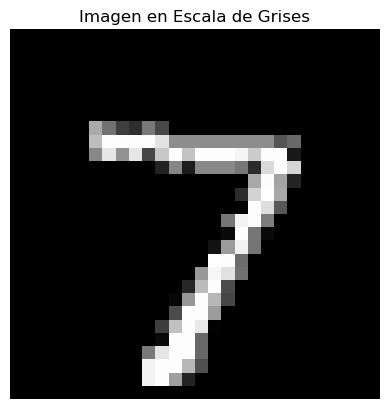

torch.Size([1, 28, 28])


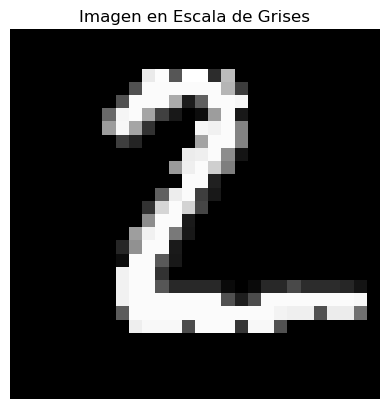

torch.Size([1, 28, 28])


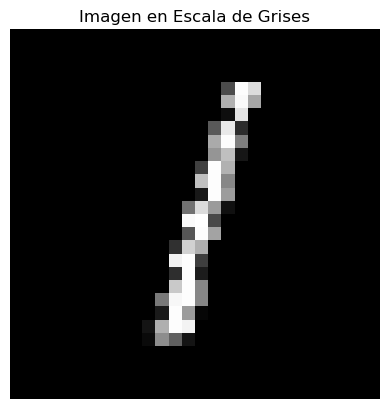

torch.Size([1, 28, 28])


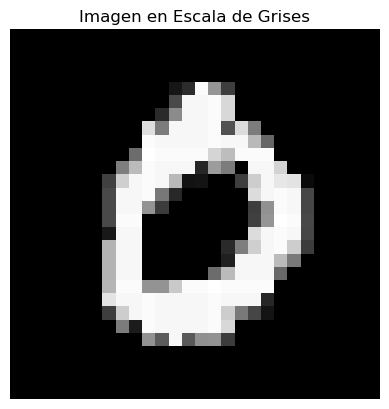

torch.Size([1, 28, 28])


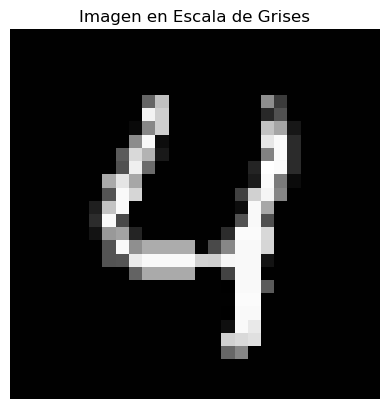

torch.Size([1, 28, 28])


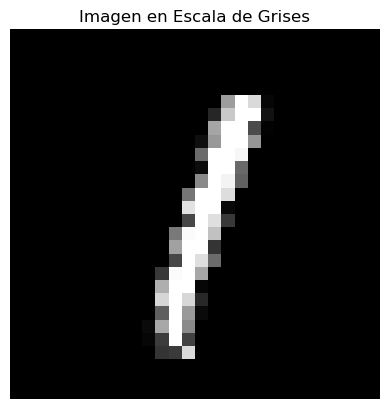

torch.Size([1, 28, 28])


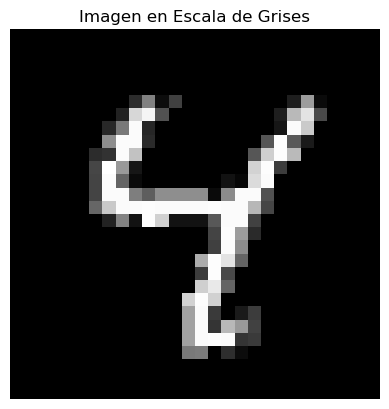

torch.Size([1, 28, 28])


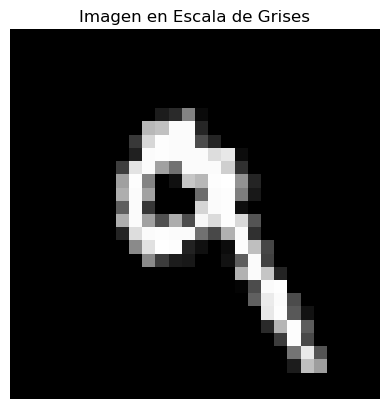

torch.Size([1, 28, 28])


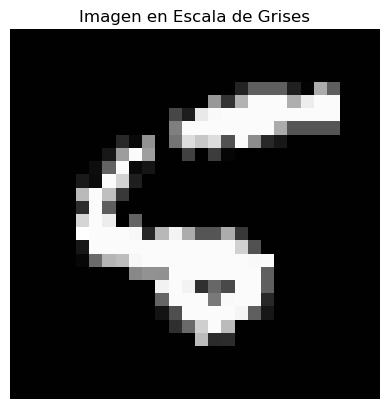

torch.Size([1, 28, 28])


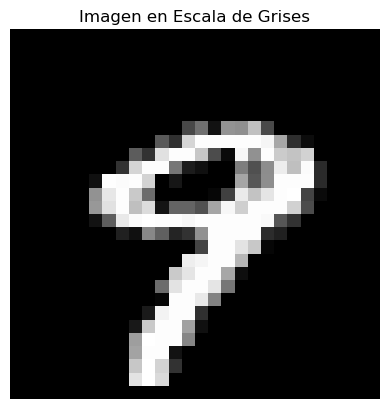

Salidas:


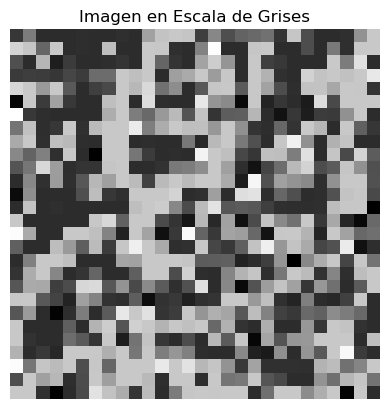

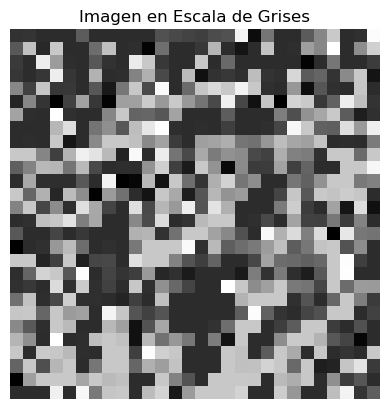

Diferencia entre el coste tensor(0.9880, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
It: 0. Rec. loss: 0.9880.
Diferencia entre el coste tensor(1.0000, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.9686, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.9388, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.9035, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.8667, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.8363, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.8083, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.7783, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.7500, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia ent

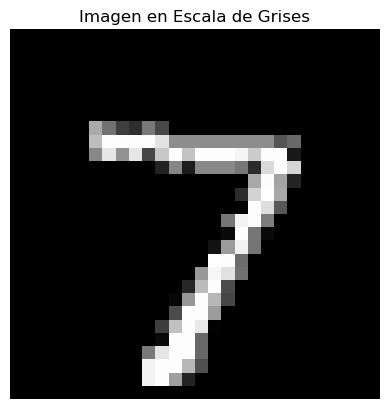

torch.Size([1, 28, 28])


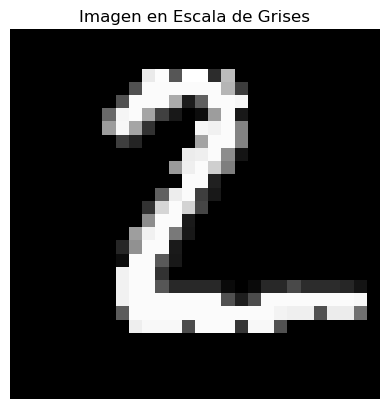

torch.Size([1, 28, 28])


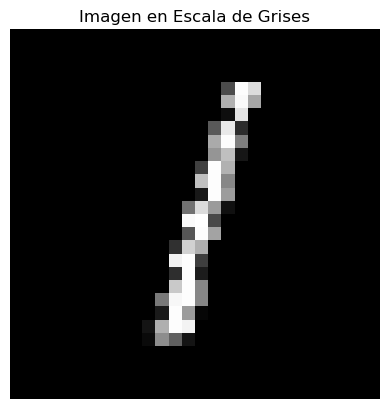

torch.Size([1, 28, 28])


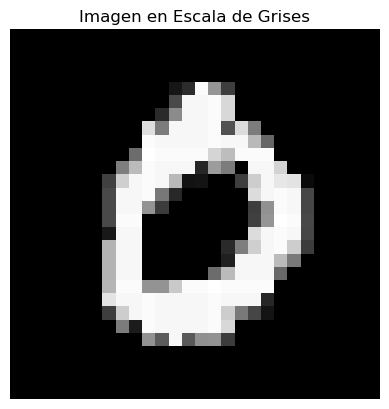

torch.Size([1, 28, 28])


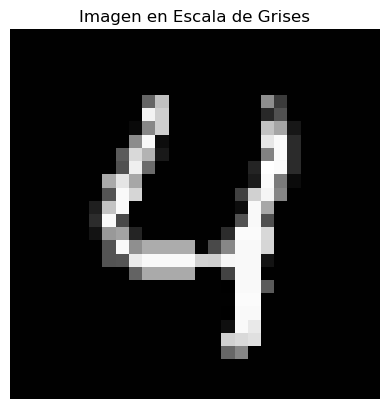

torch.Size([1, 28, 28])


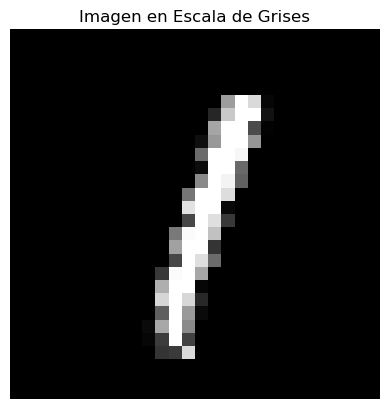

torch.Size([1, 28, 28])


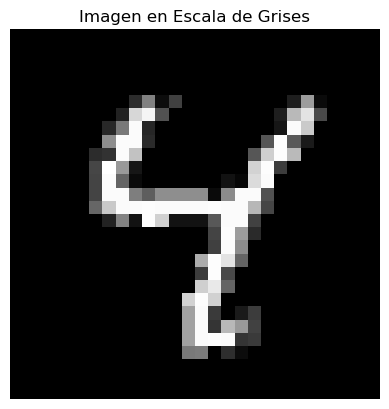

torch.Size([1, 28, 28])


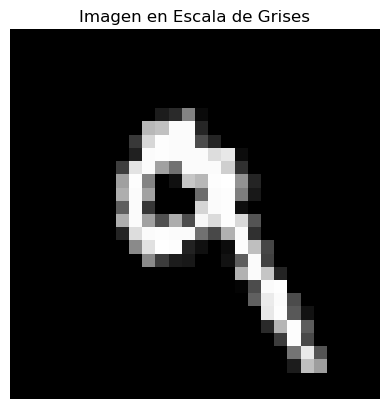

torch.Size([1, 28, 28])


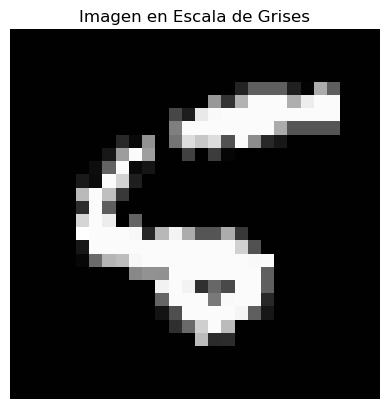

torch.Size([1, 28, 28])


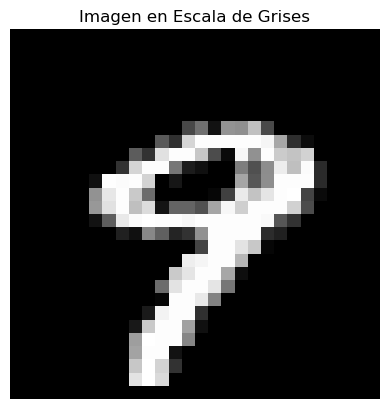

Salidas:


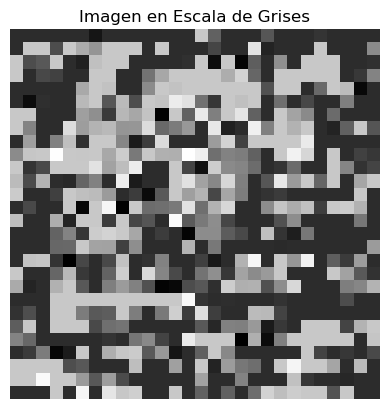

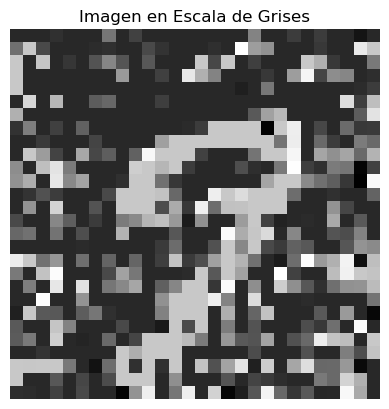

Server: Test acc: 0.9835, test loss: 0.0516

Running round: 5 of 5


100%|██████████| 118/118 [00:24<00:00,  4.73it/s]


Después de la modif antes de fedavg tensor(-0.1726)


100%|██████████| 40/40 [00:04<00:00,  8.16it/s]


Diferencia entre el coste tensor(1.0166, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
It: 0. Rec. loss: 1.0166.
Diferencia entre el coste tensor(1.0042, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.9688, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.9395, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.9130, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.8983, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.8805, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.8580, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.8472, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia entre el coste tensor(0.8345, grad_fn=<AddBackward0>)  y la longitud de gradientes 1
Diferencia ent

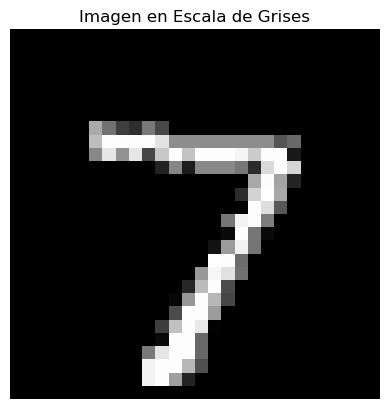

torch.Size([1, 28, 28])


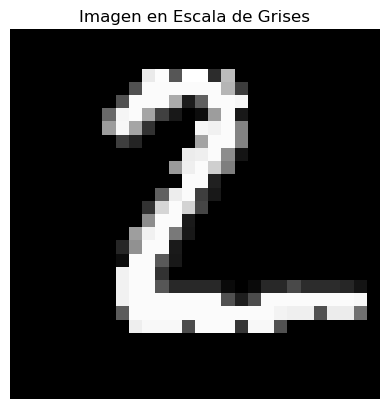

torch.Size([1, 28, 28])


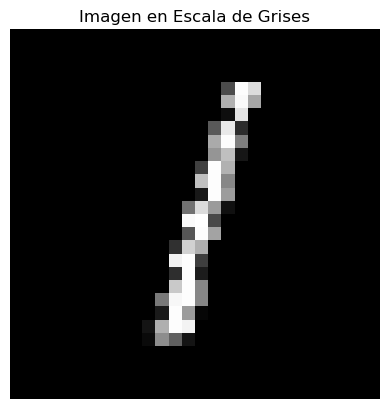

torch.Size([1, 28, 28])


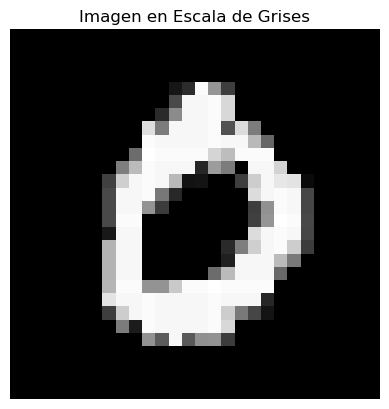

torch.Size([1, 28, 28])


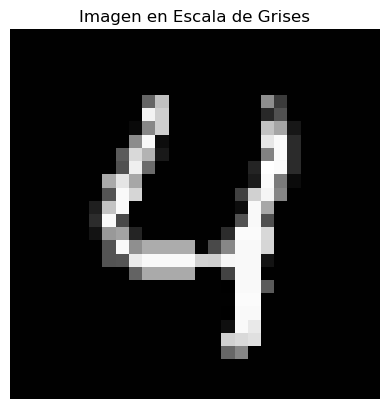

torch.Size([1, 28, 28])


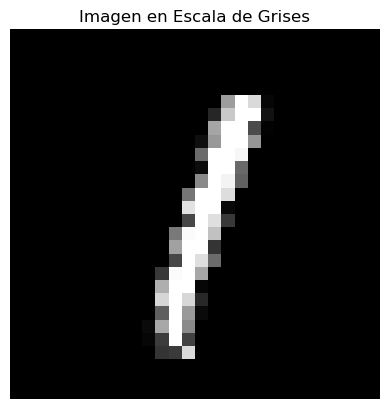

torch.Size([1, 28, 28])


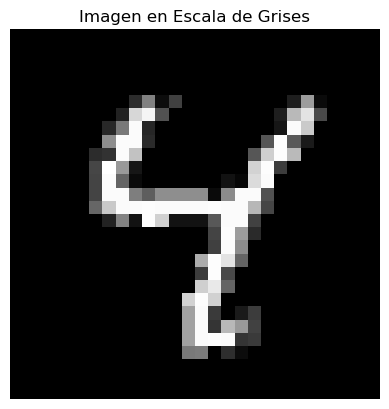

torch.Size([1, 28, 28])


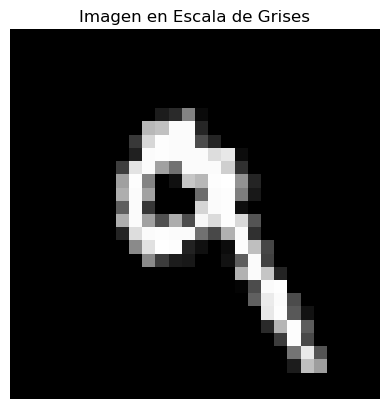

torch.Size([1, 28, 28])


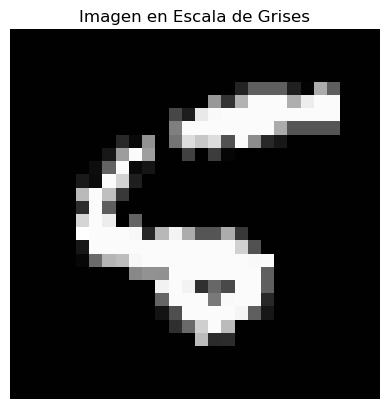

torch.Size([1, 28, 28])


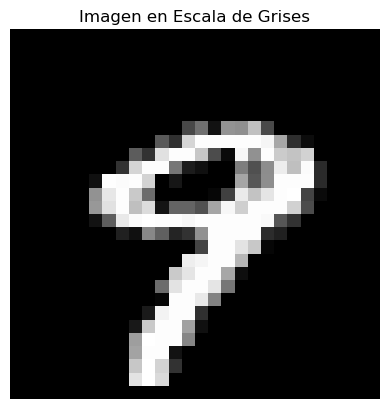

Salidas:


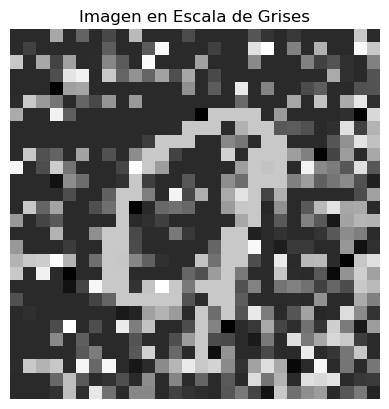

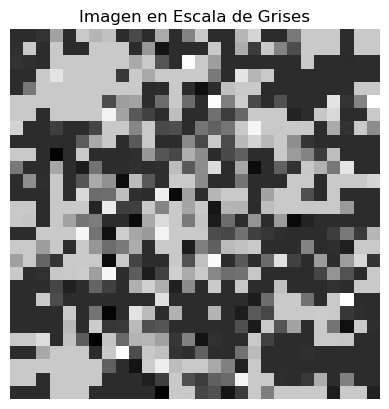

In [ ]:
train_n_rounds(5, clients_per_round = 2)